## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

###  Computing Camera Matrix

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Undistort Images

undistort uisng global variables
--- 0.010861635208129883 seconds ---
undistort from scratch
--- 0.8036563396453857 seconds ---


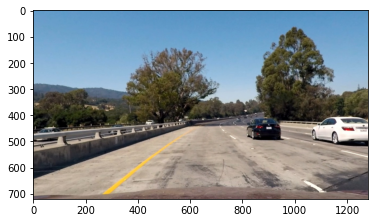

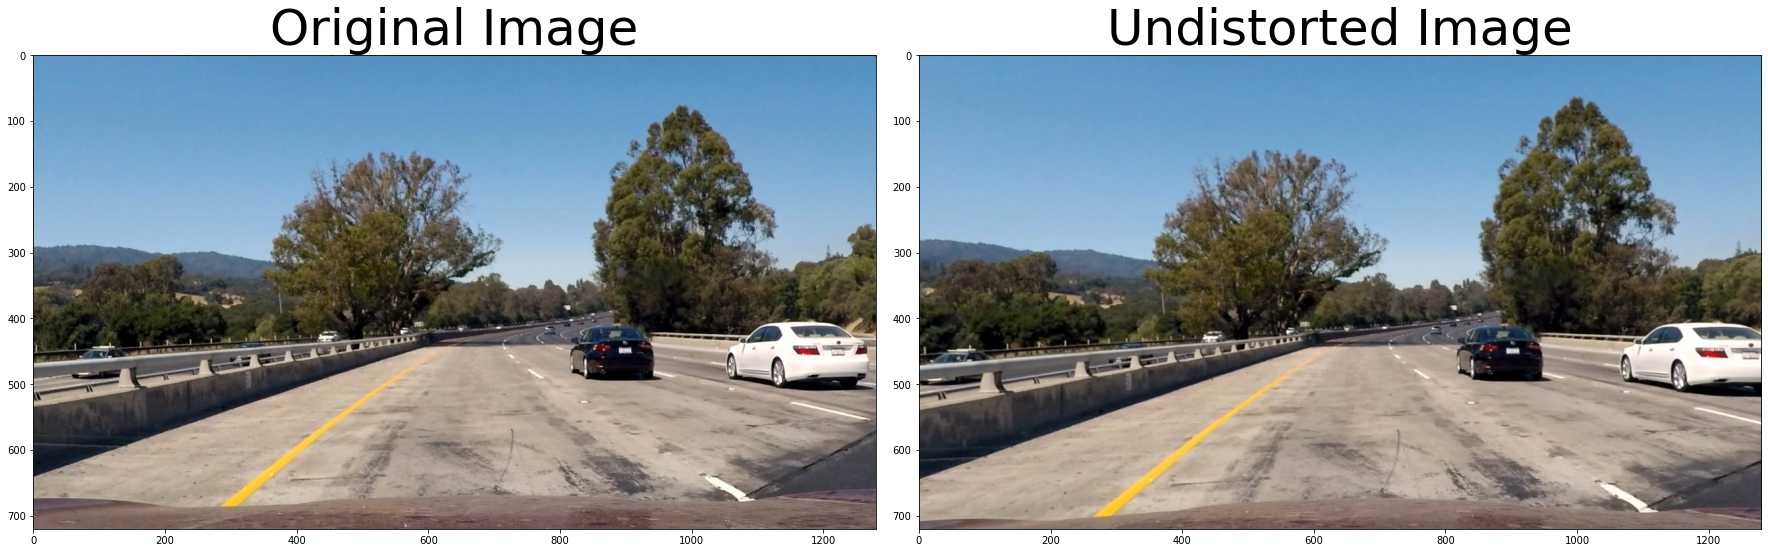

In [3]:
import time
import matplotlib.image as mpimg
# Read in an image
#img = cv2.imread('test_images/test1.jpg')
img = mpimg.imread('test_images/test1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
shape = gray.shape[::-1]
# TODO: Save extracted matrix and use it for calibrating the camera
# this way the calculation of the distortion matrix needs to be done only 1 time

# this function extracts camera matrix
def cal_distortion_params(objpoints, imgpoints, shape):
    # camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    # return camera matrix
    # undist = cv2.undistort(img, mtx, dist, None, mtx)
    return mtx, dist
# Extract camera matrix
mtx, dist = cal_distortion_params(objpoints, imgpoints, shape)

# this function uses precalculated camera matrix 
def undistort_image(img):
    # use global variables
    global mtx, dist
    # calculate undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


print("undistort uisng global variables")
start_time = time.time()  # checking performance
image_undistorted = undistort_image(img)
print("--- %s seconds ---" % (time.time() - start_time))

plt.imshow(image_undistorted)

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    # Transform image to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # calculate undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

print("undistort from scratch")
start_time = time.time()  # checking performance
undistorted = cal_undistort(img, objpoints, imgpoints)
print("--- %s seconds ---" % (time.time() - start_time))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Using Thresholding
Combining color and gradient thresholds for lane detection

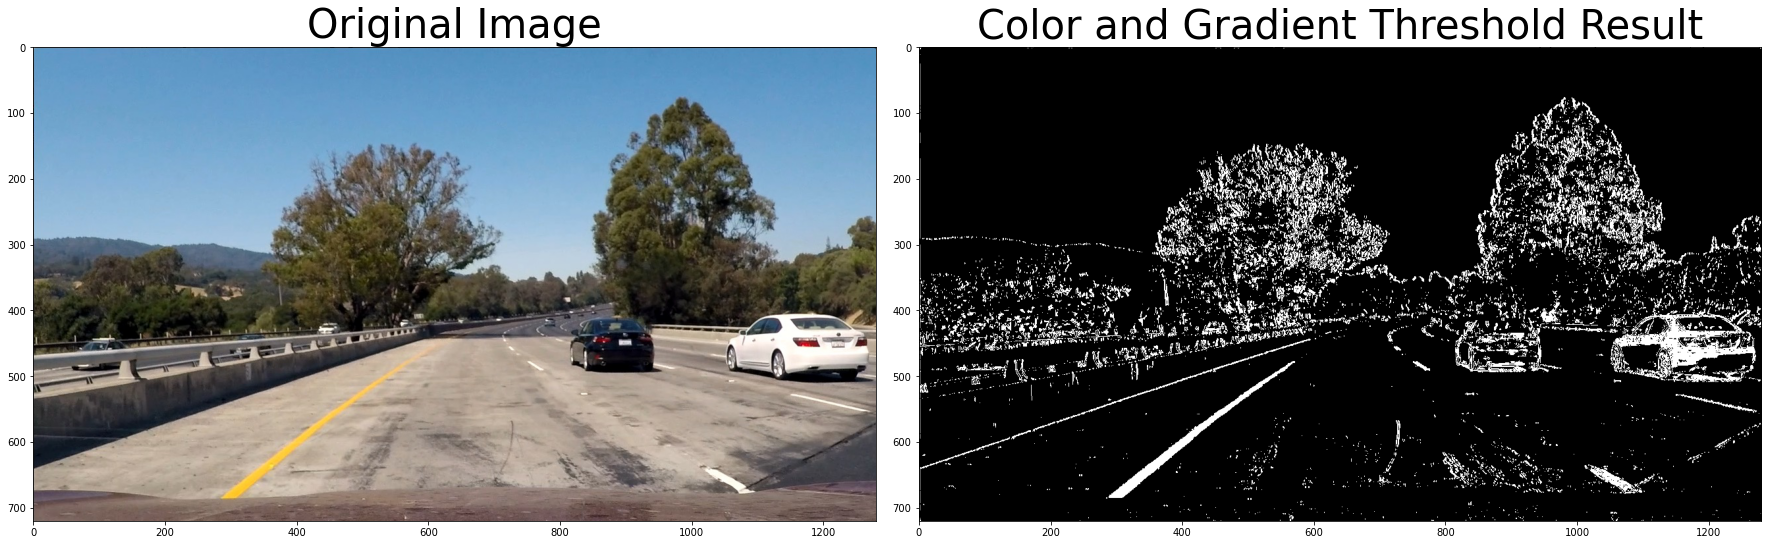

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


image = mpimg.imread('test_images/test1.jpg')

# this pipeline detects lane lines using color and gradient thresholding.
def color_grad_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
threshold_image = color_grad_threshold(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(threshold_image, cmap='gray')
ax2.set_title('Color and Gradient Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


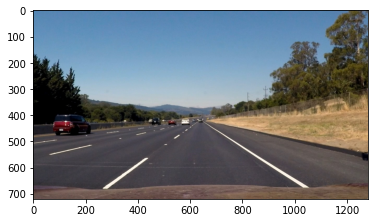

In [5]:
%matplotlib qt
image = mpimg.imread('test_images/straight_lines2.jpg')
plt.imshow(image)

## Perspective Transform 

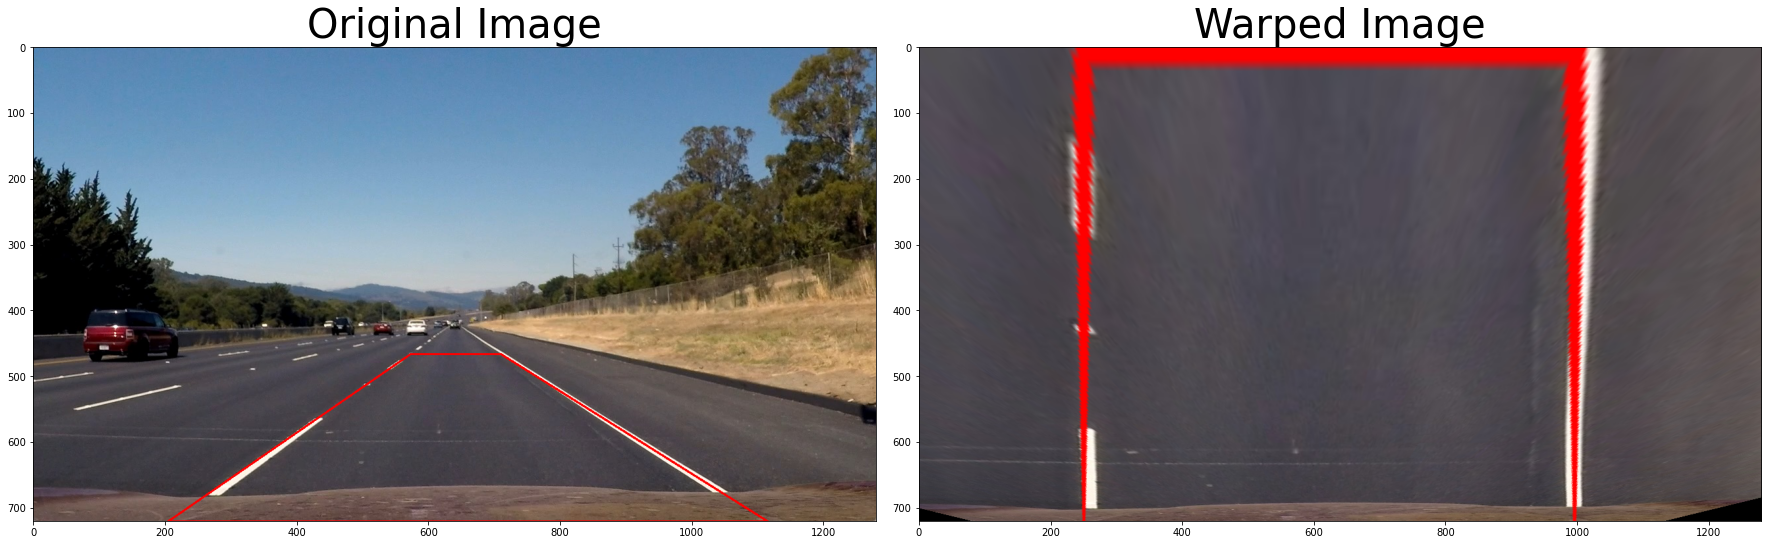

In [6]:
%matplotlib inline

# color in RGB for drawing trapezoid
color = (255,0,0)  # red
# thickness
thickness = 2
# specify corners 
top_left = (573, 466)
top_right = (710, 466)
bottom_right = (1115, 720)
bottom_left = (205, 720)
# define 4 source points for the perspective transform
src = np.float32([list(top_left),list(top_right),list(bottom_left),list(bottom_right)])
#src = np.float32([[250,0],[950,0],[250,720],[950,720]])

# define 4 destination points for the perspective transform
dst = np.float32([[250,0],[995,0],[250,720],[995,720]])
#dst = np.float32([[100,0],[1180,0],[100,720],[1180,720]])  # more "fullscreen"
# calculate transformation matrix
M_transformation = cv2.getPerspectiveTransform(src, dst)
Minv_transformation = cv2.getPerspectiveTransform(dst, src)
# image size needed for warping 
img_size = (img.shape[1], img.shape[0])

# function for perspective warping
def warp_perspective(image):
    global M_transformation, img_size
    warped = cv2.warpPerspective(image, M_transformation, img_size, flags=cv2.INTER_LINEAR)
    return warped

# Try for image with straight linesp
image = mpimg.imread('test_images/straight_lines2.jpg')
cv2.line(image, bottom_left, top_left, color, thickness)
cv2.line(image, top_left, top_right, color, thickness) 
cv2.line(image, top_right, bottom_right, color, thickness) 
cv2.line(image, bottom_right, bottom_left, color, thickness) 
warped = warp_perspective(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Warp Threshold image
warped_image = warp_perspective(threshold_image)
#plt.imshow(warped_image, cmap='gray')

## Detecting Lane Lines: 
using sliding window algorithm to detect line pixels

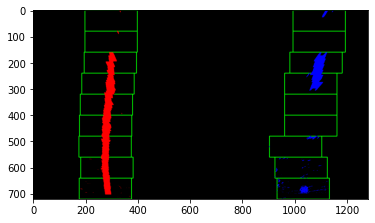

In [7]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # TODO: if less then 0
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# this function fits a ploynomial for the detected pixels
def fit_polynomial(binary_windows_image, leftx, lefty, rightx, righty, 
                   ym_per_pix=30/720, xm_per_pix=3.7/910):
    '''
    Calculates lane line points and fits a second order polynomial 
    '''
    # Find our lane pixels first
    #leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Fit a second order polynomial to each using `np.polyfit`
    out_img = binary_windows_image
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit a second order plynomial using real measures
    left_fit_cr = np.polyfit(lefty  * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_windows_image.shape[0]-1, binary_windows_image.shape[0] )
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    # Plots the left and right polynomials on the lane lines
    #print(np.int32(left_fitx))
    #print(type(ploty))
    #plt.plot(left_fitx, ploty, color='yellow')
    #out_img[np.int32(ploty), np.int32(left_fitx)] = [0, 255, 255]
    #plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr

# test on example image
# Find our lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)
# Fit polynomial
out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr = fit_polynomial(out_img,leftx, lefty, rightx, righty)
plt.imshow(out_img)

## Measure Curvature 

In [8]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr, xm_per_pix=3.7/910, ym_per_pix =30/720):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty) * ym_per_pix

    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power(1 + np.square(2 * left_fit_cr[0] * y_eval + left_fit_cr[1]), 3/2) / np.abs( 2 * left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = np.power(1 + np.square(2 * right_fit_cr[0] * y_eval + right_fit_cr[1]), 3/2) / np.abs( 2 * right_fit_cr[0])  ## Implement the calculation of the right line here
    
    
    return left_curverad, right_curverad

# Pipeline

left:  120 640
right:  1008 640
distance to the centre       0.31
1697.6319550634141 m 1159.309985906349 m


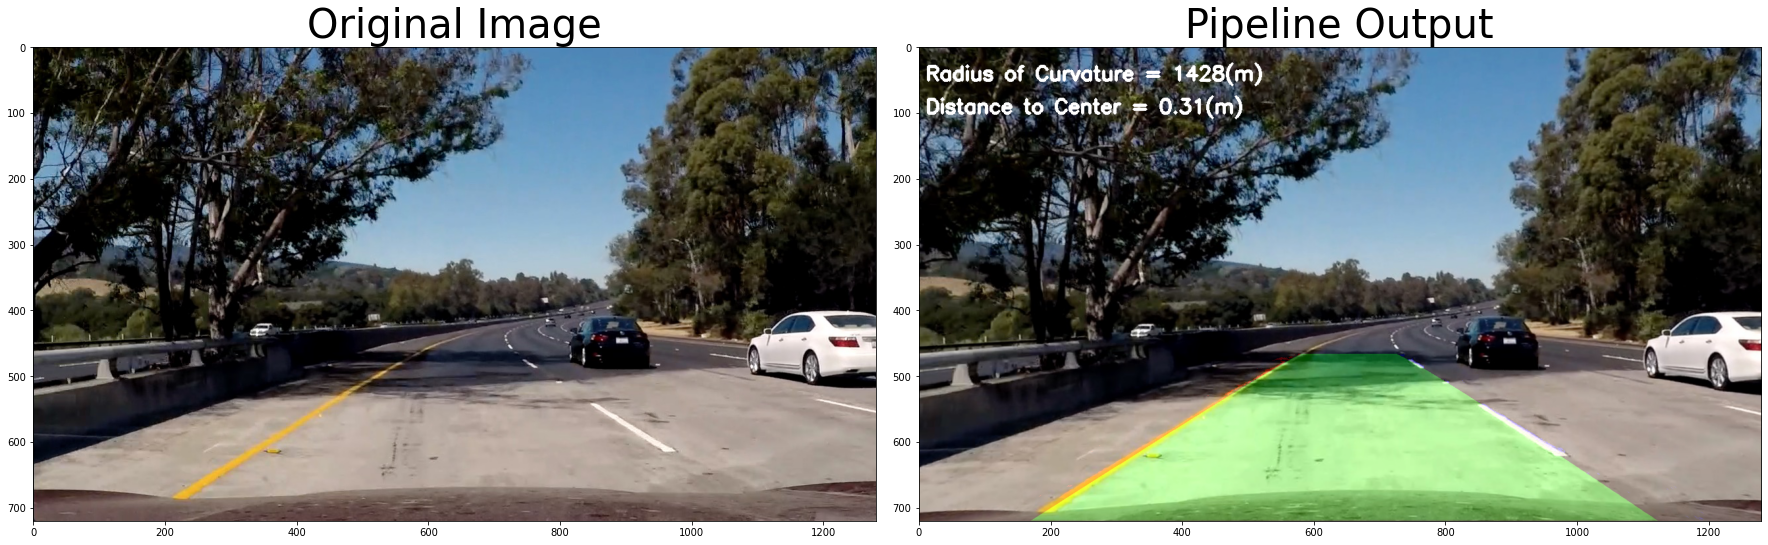

In [9]:
def pipeline(image):
    # distortion correction
    undsitorted_img= undistort_image(image)
    # color and gradient threshold
    threshold_image = color_grad_threshold(image)
    # Perspective transform
    warped_image = warp_perspective(threshold_image) 
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/910 # meters per pixel in x dimension
    
    #TODO: improve the structure
    # determine points of left and right curve
    # 
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)
    
    #plt.plot(leftx,lefty)
    #plt.plot(rightx,righty)
    print("left: ", leftx[0], lefty[0])
    print("right: ", rightx[0], righty[0])
    
    distance_to_center = (image.shape[1]/2 - (leftx[0] + rightx[0])/2) * xm_per_pix
     
    print("distance to the centre", "{:10.2f}".format(distance_to_center))
    # Fit polynomial
    out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr = fit_polynomial(out_img,leftx, lefty, rightx, righty)
    
    
    # Calculate curvature
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr, 
                                                           xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    print(left_curverad, 'm', right_curverad, 'm')

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Color left and right lane points
    # unwarp points coordinates
    # color the coordinates 
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_transformation, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undsitorted_img, 1, newwarp, 0.3, 0)
    # Print curvature value
    curvatur_text = "Radius of Curvature = " + str(int((left_curverad + right_curverad) // 2)) + "(m)"  
    distance_text = "Distance to Center = " + "{:2.2f}".format(distance_to_center) + "(m)"
    position1 = (10,50)
    position2 = (10,100)
    
    cv2.putText(result, curvatur_text, position1, cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255, 255), 3) 
    cv2.putText(result, distance_text, position2, cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255, 255), 3) 
    
    return result


# test image
image = mpimg.imread('test_images/test5.jpg')
# aply lane line detection
result = pipeline(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Output', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Test Pipeline for video

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


white_output = 'output_videos/project_video_short.mp4' # harder_challenge_video.mp4' #
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(0,5) #("harder_challenge_video.mp4").subclip(5,10) #
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False,)

t:   0%|          | 0/125 [00:00<?, ?it/s, now=None]

left:  297 640
right:  1071 641
distance to the centre      -0.18
1073.1451301856841 m 9340.873634593498 m
Moviepy - Building video output_videos/project_video_short.mp4.
Moviepy - Writing video output_videos/project_video_short.mp4

left:  297 640
right:  1071 641
distance to the centre      -0.18
1073.1451301856841 m 9340.873634593498 m


t:   3%|▎         | 4/125 [00:00<00:10, 11.11it/s, now=None]

left:  221 640
right:  1067 640
distance to the centre      -0.02
1017.285007335397 m 19326.58301422525 m
left:  298 640
right:  1051 640
distance to the centre      -0.14
930.7575218893418 m 1103.9528755232138 m


t:   5%|▍         | 6/125 [00:00<00:13,  8.56it/s, now=None]

left:  299 640
right:  1045 640
distance to the centre      -0.13
882.2435925374232 m 1502.4497346959797 m
left:  301 640
right:  1044 640
distance to the centre      -0.13
933.5195779808013 m 1636.8322494049112 m


t:   6%|▌         | 7/125 [00:00<00:14,  7.91it/s, now=None]

left:  303 640
right:  1042 640
distance to the centre      -0.13
995.7113824693491 m 1041.833049112849 m
left:  303 640
right:  1058 643
distance to the centre      -0.16


t:   6%|▋         | 8/125 [00:00<00:17,  6.63it/s, now=None]

1104.0372966282532 m 839.4381243213161 m
left:  306 640
right:  1067 641
distance to the centre      -0.19
1104.8740351765236 m 865.2598821565093 m


t:   8%|▊         | 10/125 [00:01<00:19,  5.79it/s, now=None]

left:  305 640
right:  1071 675
distance to the centre      -0.20
1103.0265792723592 m 966.5530221123375 m
left:  303 640
right:  1053 651
distance to the centre      -0.15
1066.0539375660746 m 1447.0018787257525 m


t:  10%|▉         | 12/125 [00:01<00:20,  5.60it/s, now=None]

left:  305 640
right:  1068 641
distance to the centre      -0.19
1052.2332566310008 m 3510.183897007718 m
left:  302 640
right:  1062 646
distance to the centre      -0.17
1083.5709917914915 m 3752.8663348714585 m


t:  12%|█▏        | 15/125 [00:02<00:19,  5.54it/s, now=None]

left:  302 640
right:  1064 678
distance to the centre      -0.17
1073.9772693120062 m 2919.5397472939007 m
left:  302 640
right:  990 674
distance to the centre      -0.02
1210.3517642423176 m 1725.3880777893053 m


t:  14%|█▎        | 17/125 [00:02<00:17,  6.07it/s, now=None]

left:  221 640
right:  1045 640
distance to the centre       0.03
1195.5938132376286 m 2526.6917794564215 m
left:  302 640
right:  1041 640
distance to the centre      -0.13
1281.3533193502014 m 2653.56710938565 m


t:  15%|█▌        | 19/125 [00:02<00:14,  7.10it/s, now=None]

left:  302 640
right:  1040 640
distance to the centre      -0.13
1459.3474849552078 m 3780.247029229794 m
left:  301 640
right:  1037 640
distance to the centre      -0.12
1597.6275590073217 m 1685.9397631111708 m


t:  17%|█▋        | 21/125 [00:03<00:13,  7.78it/s, now=None]

left:  299 640
right:  1038 649
distance to the centre      -0.12
1778.8098868421375 m 1766.2325128875048 m
left:  301 640
right:  1050 640
distance to the centre      -0.14
2198.8373540677 m 998.6980181785522 m


t:  18%|█▊        | 23/125 [00:03<00:12,  8.14it/s, now=None]

left:  299 640
right:  1061 647
distance to the centre      -0.16
3610.307238850757 m 787.9628390357218 m
left:  297 640
right:  1058 645
distance to the centre      -0.15
3670.330289835772 m 902.6881089470726 m


t:  20%|██        | 25/125 [00:03<00:12,  7.96it/s, now=None]

left:  293 640
right:  1058 648
distance to the centre      -0.14
3415.7403045486217 m 1081.2501749936473 m
left:  291 640
right:  1051 652
distance to the centre      -0.13
2512.8443956257393 m 1788.069560744561 m


t:  22%|██▏       | 27/125 [00:03<00:12,  7.83it/s, now=None]

left:  293 640
right:  1054 650
distance to the centre      -0.14
1841.9739292706242 m 2548.597335827178 m
left:  286 640
right:  1060 647
distance to the centre      -0.13
1842.186302920511 m 26013.437048684173 m


t:  23%|██▎       | 29/125 [00:04<00:13,  7.29it/s, now=None]

left:  286 640
right:  1059 674
distance to the centre      -0.13
1528.0541689526997 m 13143161.437225062 m
left:  205 640
right:  1042 640
distance to the centre       0.07
1553.3764487315502 m 53391.209263834186 m


t:  25%|██▍       | 31/125 [00:04<00:12,  7.45it/s, now=None]

left:  281 640
right:  1041 640
distance to the centre      -0.09
1511.6889823403387 m 1368.5184474848104 m
left:  281 640
right:  1040 640
distance to the centre      -0.08
1450.0766793184773 m 1878.7546525979976 m


t:  26%|██▋       | 33/125 [00:04<00:11,  7.88it/s, now=None]

left:  281 640
right:  1040 640
distance to the centre      -0.08
1356.151091685092 m 2391.1707962552873 m
left:  282 640
right:  1041 647
distance to the centre      -0.09
1231.7260254762857 m 986.4604379572545 m


t:  27%|██▋       | 34/125 [00:04<00:14,  6.31it/s, now=None]

left:  282 640
right:  1052 656
distance to the centre      -0.11
1404.0219669934625 m 862.9074697139603 m


t:  28%|██▊       | 35/125 [00:05<00:18,  4.88it/s, now=None]

left:  283 640
right:  1048 672
distance to the centre      -0.10
1322.5738153954815 m 739.9740390693496 m


t:  29%|██▉       | 36/125 [00:05<00:21,  4.19it/s, now=None]

left:  285 640
right:  1041 644
distance to the centre      -0.09
1317.9453469004534 m 1070.062495582082 m


t:  30%|███       | 38/125 [00:05<00:16,  5.39it/s, now=None]

left:  287 640
right:  1038 640
distance to the centre      -0.09
1134.6915005585302 m 1610.1214745934358 m
left:  290 640
right:  1027 661
distance to the centre      -0.08
1043.765831401708 m 2808.099123297092 m


t:  31%|███       | 39/125 [00:06<00:18,  4.70it/s, now=None]

left:  291 640
right:  1023 669
distance to the centre      -0.07
946.337039304578 m 41297.4712160105 m


t:  32%|███▏      | 40/125 [00:06<00:18,  4.50it/s, now=None]

left:  293 640
right:  1016 670
distance to the centre      -0.06
867.0348709886133 m 1571.5976541415534 m


t:  33%|███▎      | 41/125 [00:06<00:19,  4.26it/s, now=None]

left:  214 640
right:  968 710
distance to the centre       0.20
862.7736647546849 m 1156.8766323577743 m


t:  34%|███▎      | 42/125 [00:06<00:20,  4.13it/s, now=None]

left:  293 640
right:  1034 640
distance to the centre      -0.10
849.4866832880701 m 1473.4819026519851 m


t:  34%|███▍      | 43/125 [00:07<00:20,  3.94it/s, now=None]

left:  294 640
right:  1034 640
distance to the centre      -0.10
863.4161712589435 m 2158.8935158500303 m


t:  35%|███▌      | 44/125 [00:07<00:20,  3.91it/s, now=None]

left:  294 640
right:  1037 640
distance to the centre      -0.10
865.1862995558978 m 1753.304971604284 m
left:  294 640
right:  1045 640
distance to the centre      -0.12


t:  37%|███▋      | 46/125 [00:07<00:16,  4.67it/s, now=None]

888.9085214276682 m 2190.4396674500467 m
left:  294 640
right:  1039 641
distance to the centre      -0.11
913.4313719903032 m 927.8763092855859 m


t:  38%|███▊      | 47/125 [00:07<00:16,  4.83it/s, now=None]

left:  294 640
right:  1025 644
distance to the centre      -0.08
878.9336289835156 m 659.1872235717616 m


t:  39%|███▉      | 49/125 [00:08<00:14,  5.21it/s, now=None]

left:  294 640
right:  1035 653
distance to the centre      -0.10
1060.6117929510488 m 789.6258441765833 m
left:  294 640
right:  1032 656
distance to the centre      -0.09
1070.5346182697044 m 903.7795559016819 m


t:  40%|████      | 50/125 [00:08<00:14,  5.14it/s, now=None]

left:  294 640
right:  1047 652
distance to the centre      -0.12
1018.3619717887102 m 1143.1371049965096 m


t:  41%|████      | 51/125 [00:08<00:14,  5.13it/s, now=None]

left:  294 640
right:  1018 650
distance to the centre      -0.07
988.2101192875082 m 4833.717152711699 m
left:  294 640
right:  1022 644
distance to the centre      -0.07
1167.0647444522367 m 6073.80216636553 m


t:  42%|████▏     | 53/125 [00:09<00:14,  5.14it/s, now=None]

left:  295 640
right:  1020 656
distance to the centre      -0.07
1140.6002646310549 m 5239.706616255202 m


t:  44%|████▍     | 55/125 [00:09<00:12,  5.69it/s, now=None]

left:  210 640
right:  1037 640
distance to the centre       0.07
1077.6530940829805 m 1085.1176901861727 m
left:  294 640
right:  1034 640
distance to the centre      -0.10
1223.3463705797838 m 1546.4490462983058 m


t:  46%|████▌     | 57/125 [00:09<00:10,  6.34it/s, now=None]

left:  294 640
right:  1036 640
distance to the centre      -0.10
1607.7999893702172 m 1791.6591011171108 m
left:  293 640
right:  1009 640
distance to the centre      -0.04
1630.6225814305828 m 1996.2971025315767 m


t:  47%|████▋     | 59/125 [00:09<00:09,  6.67it/s, now=None]

left:  293 640
right:  1060 648
distance to the centre      -0.15
2071.049125348734 m 975.1383831403188 m
left:  291 640
right:  1009 646
distance to the centre      -0.04
2464.5513262977297 m 752.1311892850072 m


t:  49%|████▉     | 61/125 [00:10<00:09,  6.50it/s, now=None]

left:  293 640
right:  955 675
distance to the centre       0.07
2400.21095535678 m 643.4863654934876 m
left:  293 640
right:  1008 652
distance to the centre      -0.04
2360.078820815696 m 1326.4020606310612 m


t:  50%|████▉     | 62/125 [00:10<00:12,  5.24it/s, now=None]

left:  291 640
right:  1031 642
distance to the centre      -0.09
1891.2056036298586 m 1735.1284063299797 m


t:  50%|█████     | 63/125 [00:10<00:11,  5.24it/s, now=None]

left:  291 640
right:  1003 644
distance to the centre      -0.03
1610.307853734993 m 3632.478963574994 m
left:  289 640
right:  1007 688
distance to the centre      -0.03


t:  52%|█████▏    | 65/125 [00:11<00:11,  5.40it/s, now=None]

1476.2099369856908 m 12083.986966562019 m
left:  287 640
right:  1004 674
distance to the centre      -0.02
1382.193396307431 m 1693.7143519067806 m


t:  54%|█████▎    | 67/125 [00:11<00:10,  5.79it/s, now=None]

left:  285 640
right:  1021 640
distance to the centre      -0.05
1170.951572082725 m 2446.6375956445654 m
left:  285 640
right:  1020 640
distance to the centre      -0.05
1166.712174979197 m 8229.712050882526 m


t:  54%|█████▍    | 68/125 [00:11<00:09,  5.82it/s, now=None]

left:  282 640
right:  1020 640
distance to the centre      -0.04
1122.499830778101 m 16037.477124575862 m
left:  279 640
right:  1018 640
distance to the centre      -0.03
1153.7678084260772 m 2355.7616335639873 m


t:  57%|█████▋    | 71/125 [00:12<00:09,  5.83it/s, now=None]

left:  279 640
right:  1042 642
distance to the centre      -0.08
1113.4017731244137 m 1355.0952210775563 m
left:  277 640
right:  1012 640
distance to the centre      -0.02
1106.449814186938 m 1145.1652179540113 m


t:  58%|█████▊    | 72/125 [00:12<00:09,  5.44it/s, now=None]

left:  277 640
right:  1012 654
distance to the centre      -0.02
1210.9371975390254 m 829.5064334071953 m


t:  58%|█████▊    | 73/125 [00:12<00:10,  5.05it/s, now=None]

left:  277 640
right:  1004 671
distance to the centre      -0.00
1335.3887046296204 m 1025.0538613152873 m


t:  59%|█████▉    | 74/125 [00:12<00:10,  4.86it/s, now=None]

left:  275 640
right:  1002 673
distance to the centre       0.01
1327.615941466848 m 1373.261461965439 m


t:  60%|██████    | 75/125 [00:12<00:10,  4.76it/s, now=None]

left:  275 640
right:  1022 658
distance to the centre      -0.03
1459.1602270859985 m 2904.98070702616 m


t:  61%|██████    | 76/125 [00:13<00:10,  4.79it/s, now=None]

left:  274 640
right:  1013 661
distance to the centre      -0.01
1552.8497601061813 m 7386.155129991065 m
left:  274 640
right:  1013 665
distance to the centre      -0.01
1922.1050816769864 m 5875.012938818747 m


t:  63%|██████▎   | 79/125 [00:13<00:08,  5.44it/s, now=None]

left:  271 640
right:  1008 640
distance to the centre       0.00
2120.027726654006 m 4418.821784315883 m
left:  194 640
right:  1012 640
distance to the centre       0.15
2494.319541098291 m 3991.7318120045347 m


t:  64%|██████▍   | 80/125 [00:13<00:08,  5.12it/s, now=None]

left:  269 640
right:  1012 640
distance to the centre      -0.00
2355.7939701115306 m 1437.5676812118409 m


t:  66%|██████▌   | 82/125 [00:14<00:07,  5.61it/s, now=None]

left:  267 640
right:  1013 640
distance to the centre       0.00
3058.672261450103 m 1899.747689174079 m
left:  266 640
right:  1010 640
distance to the centre       0.01
5187.758467856438 m 1923.7399884343458 m


t:  66%|██████▋   | 83/125 [00:14<00:07,  5.92it/s, now=None]

left:  262 640
right:  940 653
distance to the centre       0.16
8045.0571220094125 m 1760.2354798734873 m


t:  67%|██████▋   | 84/125 [00:14<00:07,  5.45it/s, now=None]

left:  261 640
right:  1015 673
distance to the centre       0.01
15383.692327870202 m 900.3696945108263 m
left:  257 640
right:  1027 645
distance to the centre      -0.01


t:  68%|██████▊   | 85/125 [00:14<00:07,  5.46it/s, now=None]

7686.218033322657 m 718.5037199810869 m
left:  255 640
right:  1021 645
distance to the centre       0.01
12624.885145271346 m 844.3333222998248 m


t:  70%|██████▉   | 87/125 [00:15<00:06,  5.49it/s, now=None]

left:  254 640
right:  1018 640
distance to the centre       0.02
4017.8033995900428 m 1043.0102440055664 m
left:  255 640
right:  1020 642
distance to the centre       0.01
2339.909359574134 m 2924.812874715328 m


t:  71%|███████   | 89/125 [00:15<00:06,  5.36it/s, now=None]

left:  257 640
right:  1020 642
distance to the centre       0.01
1619.7196383699725 m 6820.281475983127 m


t:  72%|███████▏  | 90/125 [00:15<00:06,  5.22it/s, now=None]

left:  257 640
right:  1018 652
distance to the centre       0.01
1460.4678684990056 m 15434.52677865345 m
left:  261 640
right:  1013 645
distance to the centre       0.01
1335.9550819211524 m 1986.7949407487502 m


t:  74%|███████▎  | 92/125 [00:16<00:06,  5.38it/s, now=None]

left:  261 640
right:  1008 640
distance to the centre       0.02
1234.772907417911 m 2780.223244056193 m
left:  262 640
right:  1009 640
distance to the centre       0.02


t:  74%|███████▍  | 93/125 [00:16<00:06,  5.29it/s, now=None]

1276.4217500025763 m 3876.6818587560247 m


t:  75%|███████▌  | 94/125 [00:16<00:06,  5.07it/s, now=None]

left:  263 640
right:  1008 640
distance to the centre       0.02
1260.535044244735 m 2017.4632292009146 m


t:  76%|███████▌  | 95/125 [00:16<00:06,  4.95it/s, now=None]

left:  265 640
right:  1012 640
distance to the centre       0.01
1271.3880154531453 m 1146.6504189706973 m


t:  77%|███████▋  | 96/125 [00:16<00:05,  4.90it/s, now=None]

left:  263 640
right:  1027 669
distance to the centre      -0.02
1194.7571508192334 m 1212.6508469196115 m
left:  265 640
right:  1028 671
distance to the centre      -0.03
1256.1839013868994 m 756.2316686619145 m


t:  78%|███████▊  | 98/125 [00:17<00:04,  5.41it/s, now=None]

left:  266 640
right:  995 712
distance to the centre       0.04
1186.6810586420079 m 992.598979648506 m
left:  266 640
right:  1027 683
distance to the centre      -0.03


t:  79%|███████▉  | 99/125 [00:17<00:05,  5.14it/s, now=None]

1280.1174431717372 m 1168.6791235731134 m
left:  267 640
right:  1020 649
distance to the centre      -0.01


t:  80%|████████  | 100/125 [00:17<00:05,  4.87it/s, now=None]

1195.3804816590682 m 2877.5362504326786 m
left:  267 640
right:  1013 682
distance to the centre       0.00


t:  81%|████████  | 101/125 [00:17<00:05,  4.76it/s, now=None]

1234.6584418135965 m 2512.2482832642645 m
left:  270 640
right:  1030 641
distance to the centre      -0.04
1159.18286634496 m 3056.535564504199 m


t:  82%|████████▏ | 103/125 [00:18<00:04,  5.03it/s, now=None]

left:  271 640
right:  1025 665
distance to the centre      -0.03
1215.3966825448983 m 2085.4980489040477 m
left:  194 640
right:  1004 640
distance to the centre       0.17


t:  83%|████████▎ | 104/125 [00:18<00:04,  5.04it/s, now=None]

1211.385952958118 m 1448.2074287739774 m
left:  274 640
right:  1005 640
distance to the centre       0.00
1270.1360547480851 m 1591.969009730114 m


t:  86%|████████▌ | 107/125 [00:19<00:03,  5.27it/s, now=None]

left:  273 640
right:  1010 640
distance to the centre      -0.01
1292.0237585801126 m 1818.266961569902 m
left:  274 640
right:  1013 640
distance to the centre      -0.01
1406.7181312454077 m 2684.1714170502623 m


t:  86%|████████▋ | 108/125 [00:19<00:02,  5.71it/s, now=None]

left:  273 640
right:  1021 648
distance to the centre      -0.03
1465.6326300587566 m 2113.943949679319 m
left:  275 640
right:  1043 649
distance to the centre      -0.08
1553.2952821196814 m 1123.9754051078523 m


t:  88%|████████▊ | 110/125 [00:19<00:02,  5.59it/s, now=None]

left:  275 640
right:  1044 665
distance to the centre      -0.08
1553.0211127535206 m 844.6652538113166 m
left:  275 640
right:  1049 650
distance to the centre      -0.09
1524.90512339165 m 1056.0120185249946 m


t:  90%|████████▉ | 112/125 [00:19<00:02,  5.58it/s, now=None]

left:  278 640
right:  1048 640
distance to the centre      -0.09
1344.251813056754 m 1558.9718103590387 m
left:  277 640
right:  1053 651
distance to the centre      -0.10
1300.0236419896341 m 1448.336830606521 m


t:  92%|█████████▏| 115/125 [00:20<00:01,  6.29it/s, now=None]

left:  278 640
right:  1047 665
distance to the centre      -0.09
1177.4797788222977 m 3472.384844190526 m
left:  279 640
right:  1054 654
distance to the centre      -0.11
1081.1086976937434 m 12741.226230229928 m


t:  93%|█████████▎| 116/125 [00:20<00:01,  6.55it/s, now=None]

left:  281 640
right:  1051 654
distance to the centre      -0.11
1032.5873041797201 m 12217.210231887093 m
left:  282 640
right:  1021 640
distance to the centre      -0.05


t:  94%|█████████▎| 117/125 [00:20<00:01,  6.03it/s, now=None]

1026.0227024385902 m 1126.966379431174 m
left:  283 640
right:  1022 640
distance to the centre      -0.05


t:  95%|█████████▌| 119/125 [00:21<00:01,  5.86it/s, now=None]

1053.4103721988884 m 1374.9732687330497 m
left:  285 640
right:  1022 640
distance to the centre      -0.05
1079.7254706278775 m 1424.2433414778309 m


t:  96%|█████████▌| 120/125 [00:21<00:00,  5.83it/s, now=None]

left:  285 640
right:  1022 640
distance to the centre      -0.05
1070.7824160507648 m 1045.0102592614433 m
left:  287 640
right:  1036 640
distance to the centre      -0.09
1103.0334143807606 m 755.4005372927722 m


t:  98%|█████████▊| 122/125 [00:21<00:00,  5.78it/s, now=None]

left:  289 640
right:  1039 641
distance to the centre      -0.10
1073.9598091444032 m 772.7128076407414 m


t:  98%|█████████▊| 123/125 [00:21<00:00,  5.43it/s, now=None]

left:  290 640
right:  1039 641
distance to the centre      -0.10
1087.206928277052 m 781.0823088582077 m
left:  293 640
right:  1044 645
distance to the centre      -0.12
1020.8423593103587 m 915.6033175541871 m


left:  293 640
right:  1033 640
distance to the centre      -0.09
995.2880293217783 m 1467.1865465893295 m
left:  294 640
right:  1037 654
distance to the centre      -0.10
969.5707032579804 m 1420.845275231991 m


Moviepy - Done !
Moviepy - video ready output_videos/project_video_short.mp4
CPU times: user 2min 21s, sys: 4.21 s, total: 2min 25s
Wall time: 23.3 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))